# CC<sub>1/2</sub> vs. redundancy

## Load the partially-merged data

In [4]:
from mdx2.utils import loadobj
import pandas as pd
import numpy as np

Crystal  = loadobj('../processing/mdx2/split_00/geometry.nxs','crystal')
Symmetry = loadobj('../processing/mdx2/split_00/geometry.nxs','symmetry')

def hkl2s(h,k,l):
    """Compute the magnitude of s from Miller indices."""
    UB = Crystal.ub_matrix
    s = UB @ np.stack((h,k,l))
    return np.sqrt(np.sum(s*s,axis=0))

def isInteger(h):
    return (h.round()-h).abs() < 0.00001

def isReflection(h,k,l):
    return isInteger(h) & isInteger(k) & isInteger(l) & Symmetry.is_reflection(h,k,l)

def load_refl(fn):
    t1 = loadobj(fn,'hkl_table')
    t1.s = hkl2s(t1.h,t1.k,t1.l)
    df1 = t1.to_frame()
    df1h = df1[isReflection(df1['h'],df1['k'],df1['l'])].set_index(['h','k','l'])
    df1 = df1[~isReflection(df1['h'],df1['k'],df1['l'])].set_index(['h','k','l'])
    return df1, df1h

def calc_cc(df,*cols):
    s_bin = pd.cut(df.s,np.linspace(0.03,.8,78)) 
    corr_binned = df.groupby(s_bin)[list(cols)].corr(method='pearson').unstack()
    x = df.groupby(s_bin)['s'].mean().values
    y = corr_binned[cols].values
    return x,y
    
df1, df1h = load_refl('../processing/mdx2/partial_merge/merged_1.nxs')
df2, df2h = load_refl('../processing/mdx2/partial_merge/merged_2.nxs')
df4, df4h = load_refl('../processing/mdx2/partial_merge/merged_4.nxs')
df8, df8h = load_refl('../processing/mdx2/partial_merge/merged_8.nxs')
df12, df12h = load_refl('../processing/mdx2/partial_merge/merged_12.nxs')
df17, df17h = load_refl('../processing/mdx2/partial_merge/merged_17.nxs')

Reading crystal from ../processing/mdx2/split_00/geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from ../processing/mdx2/split_00/geometry.nxs
  importing as Symmetry from mdx2.geometry
Reading hkl_table from ../processing/mdx2/partial_merge/merged_1.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/partial_merge/merged_2.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/partial_merge/merged_4.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/partial_merge/merged_8.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/partial_merge/merged_12.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from ../processing/mdx2/partial_merge/merged_17.nxs
  importing as HKLTable from mdx2.data


In [5]:
# what is the redundancy for each partial dataset?

pd.DataFrame(
    data=[
        df1['count'].mean(),
        df2['count'].mean(),
        df4['count'].mean(),
        df8['count'].mean(),
        df17['count'].mean(),
    ],
    index=[1,2,4,8,17]
)

,0
1,5.618030
2,10.227434
4,19.924898
8,39.422286
17,80.841146


## Figure S2

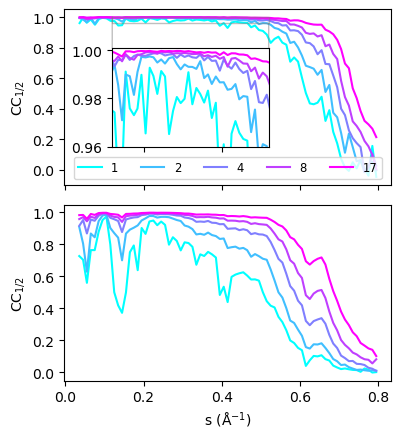

In [6]:
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(4.2, 4.5))
colors = plt.cm.cool(np.linspace(0, 1, 5))

# add zoom insets
axin1 = ax1.inset_axes([0.12,0.15,0.4,0.65], transform=ax1.transData)
axin1.set_ylim(0.96,1.001)
axin1.set_xlim(0.12,0.52)
ax1.indicate_inset_zoom(axin1)

x,y = calc_cc(df1h,'group_0_intensity','group_1_intensity')
ax1.plot(x,y,label='1',color=colors[0])
axin1.plot(x,y,color=colors[0])

x,y = calc_cc(df2h,'group_0_intensity','group_1_intensity')
ax1.plot(x,y,label='2',color=colors[1])
axin1.plot(x,y,color=colors[1])

x,y = calc_cc(df4h,'group_0_intensity','group_1_intensity')
ax1.plot(x,y,label='4',color=colors[2])
axin1.plot(x,y,color=colors[2])

x,y = calc_cc(df8h,'group_0_intensity','group_1_intensity')
ax1.plot(x,y,label='8',color=colors[3])
axin1.plot(x,y,color=colors[3])

x,y = calc_cc(df17h,'group_0_intensity','group_1_intensity')
ax1.plot(x,y,label='17',color=colors[4])
axin1.plot(x,y,color=colors[4])

x,y = calc_cc(df1,'group_0_intensity','group_1_intensity')
ax2.plot(x,y,label='1',color=colors[0])

x,y = calc_cc(df2,'group_0_intensity','group_1_intensity')
ax2.plot(x,y,label='2',color=colors[1])

x,y = calc_cc(df4,'group_0_intensity','group_1_intensity')
ax2.plot(x,y,label='4',color=colors[2])

x,y = calc_cc(df8,'group_0_intensity','group_1_intensity')
ax2.plot(x,y,label='8',color=colors[3])

x,y = calc_cc(df17,'group_0_intensity','group_1_intensity')
ax2.plot(x,y,label='17',color=colors[4])

axin1.xaxis.set_ticklabels([])
ax2.set_xlabel('s (Å$^{-1}$)')
[ax.set_ylabel('CC$_{1/2}$') for ax in [ax1,ax2]]
ax1.legend(ncol=5,fontsize='small',loc='lower center')
plt.tight_layout()

!mkdir -p figures
plt.savefig('figures/figs2.pdf',transparent=True)